In [48]:
import pandas as pd
from utils import db_connect
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

In [49]:
# Establecer la conexión a la base de datos
engine = db_connect()

if engine:
    print("Conexión exitosa")

data = pd.read_sql_table('tabla seguro', engine)

pd.set_option('display.max_columns', None)  # muestra todas las columnas del dataframe
data.head()

Conexión exitosa


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [50]:
print(data.shape)
data.info()

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [51]:
data.isnull().any().any()

False

In [52]:
data.duplicated().sum()

1

In [53]:
data = data.drop_duplicates().reset_index(drop = True)
data.duplicated().sum()

0

Usamos pd.factorize para codificar las columnas para preservar el orden de las categorias, a diferencia de LabelEncoder, que usa menos memoria pero no mantiene el orden de las categorias.

Nos decidimos por esta forma ya que tenemos pocas categorías distintas, y pd.factorize devuelve tanto los códigos numéricos como las categorías originales, lo que es útil para el análisis.


In [54]:
data["sex_num"] = pd.factorize(data["sex"])[0]
data["smoker_num"] = pd.factorize(data["smoker"])[0]
data["region_num"] = pd.factorize(data["region"])[0]

data.head()


,age,sex,bmi,children,smoker,region,charges,sex_num,smoker_num,region_num
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2


In [55]:
data_num = data[["age", "bmi", "children", "sex_num", "smoker_num", "region_num", "charges"]].copy() # .copy() para crear dataframe independiente al original
data_num.corr()

,age,bmi,children,sex_num,smoker_num,region_num,charges
age,1.000000,0.109344,0.041536,-0.019814,0.025587,-0.001626,0.298308
bmi,0.109344,1.000000,0.012755,0.046397,-0.003746,-0.157574,0.198401
children,0.041536,0.012755,1.000000,0.017848,-0.007331,-0.016258,0.067389
sex_num,-0.019814,0.046397,0.017848,1.000000,-0.076596,-0.004936,0.058044
smoker_num,0.025587,-0.003746,-0.007331,-0.076596,1.000000,-0.002358,-0.787234
region_num,-0.001626,-0.157574,-0.016258,-0.004936,-0.002358,1.000000,0.006547
charges,0.298308,0.198401,0.067389,0.058044,-0.787234,0.006547,1.000000


Edad y Costos: Hay una correlación positiva moderada entre la edad y los costos médicos. Esto sugiere que a medida que la edad aumenta, es probable que los costos médicos también aumenten, lo cual es razonable ya que las personas mayores tienden a tener más problemas de salud y pueden requerir más atención médica.

IMC (BMI) y Costos: Existe una correlación positiva leve entre el índice de masa corporal (IMC) y los costos médicos. Esto indica que las personas con un IMC más alto tienden a tener costos médicos ligeramente más altos. Sin embargo, la correlación no es muy fuerte.

Fumadores y Costos: La correlación entre el hecho de ser fumador y los costos médicos es bastante alta y negativa. Esto sugiere que los fumadores tienden a tener costos médicos mucho más altos en comparación con los no fumadores. Esta es una observación significativa y coherente con la literatura médica, ya que el hábito de fumar está asociado con una variedad de problemas de salud.

Región y Costos: La correlación entre la región y los costos médicos es muy baja, lo que indica que la región donde reside una persona tiene una influencia mínima en sus costos médicos.

Sexo y Costos: La correlación entre el sexo y los costos médicos es muy baja, lo que indica que no hay una relación significativa entre el sexo de una persona y sus costos médicos.

En resumen, la edad, el IMC y el hábito de fumar parecen ser los factores más influyentes en los costos médicos, según esta matriz de correlación.


Vemos que apenas hay correlacion entre la región y la prima de seguro, algo normal, ya que si bien una region puede tener una tendencia hacia una característica influyente mayor que la otra, no tiene que verse reflejada en todos los sujetos de dicha zona, por lo que sería injusto que, por ejemplo, su prima aumentase por proceder de una zona con mayor índice de fumadores, a pesar de que el sujeto concreto no haya fumado en su vida.
Lo mismo ocurre en relación al sexo.

Por tanto, eliminaremos las variables.

In [56]:
data.drop(['region', 'region_num', 'sex', 'sex_num'], axis=1, inplace=True)
data_num.drop(['region_num', 'sex_num'], axis=1, inplace=True)
data_num.head()

,age,bmi,children,smoker_num,charges
0,19,27.900,0,0,16884.92400
1,18,33.770,1,1,1725.55230
2,28,33.000,3,1,4449.46200
3,33,22.705,0,1,21984.47061
4,32,28.880,0,1,3866.85520


Análisis de variables univariantes (categóricas)

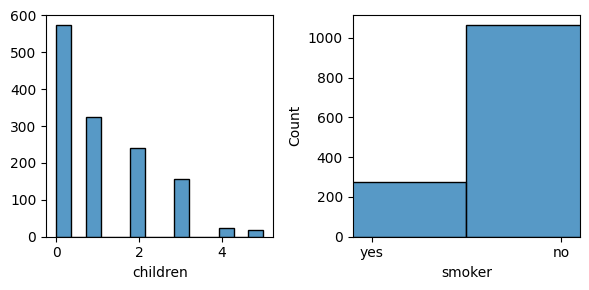

In [57]:
fig, axis = plt.subplots(1, 2, figsize = (6, 3))

sns.histplot(ax = axis[0], data = data, x = "children").set(ylabel = None)
sns.histplot(ax = axis[1], data = data, x = "smoker").set_xlim(-0.1, 1.1)

plt.tight_layout()  # Ajustar el layout

plt.show()

Análisis sobre variables numéricas

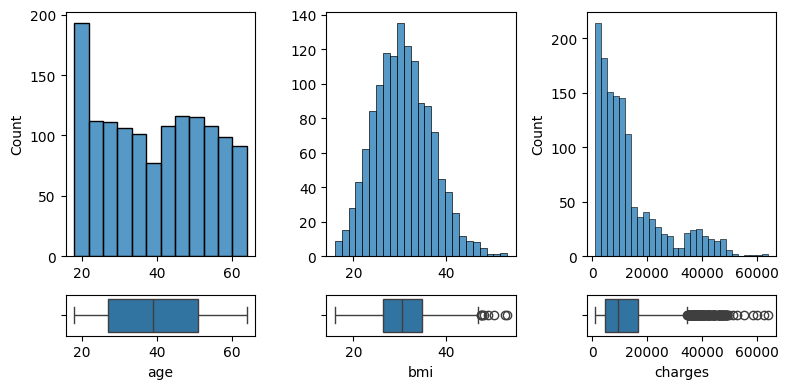

In [58]:
fig, axis = plt.subplots(2, 3, figsize = (8, 4), gridspec_kw={'height_ratios': [6, 1]})

sns.histplot(ax = axis[0, 0], data = data, x = "age").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = data, x = "age")

sns.histplot(ax = axis[0, 1], data = data, x = "bmi").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = data, x = "bmi")

sns.histplot(ax = axis[0, 2], data = data, x = "charges").set(xlabel = None)
sns.boxplot(ax = axis[1, 2], data = data, x = "charges")

plt.tight_layout()

plt.show()

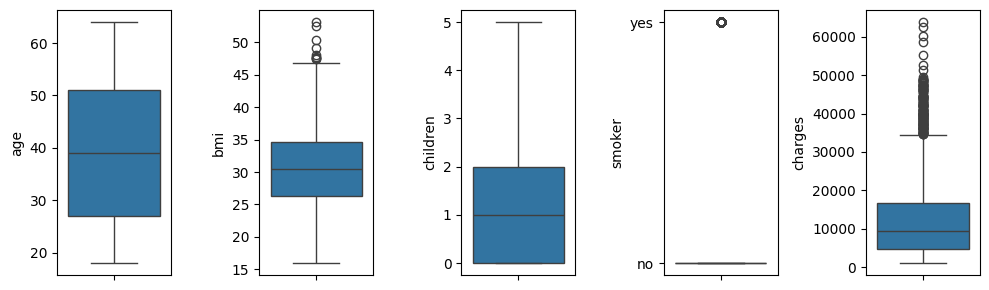

In [59]:
fig, axis = plt.subplots(1, 5, figsize = (10, 3))

sns.boxplot(ax = axis[0], data = data, y = "age")
sns.boxplot(ax = axis[1], data = data, y = "bmi")
sns.boxplot(ax = axis[2], data = data, y = "children")
sns.boxplot(ax = axis[3], data = data, y = "smoker")
sns.boxplot(ax = axis[4], data = data, y = "charges")

plt.tight_layout()

plt.show()

In [60]:
data_num.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
smoker_num,1337.0,0.795064,0.403806,0.0000,1.000,1.0000,1.00000,1.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


 - Valores Atípicos

Observamos que tenemos dos columnas con valores atípicos: 'bmi' y 'charges'

In [61]:
bmi_stats = data['bmi'].describe()
charges_stats = data['charges'].describe()
charges_stats

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

In [62]:
bmi_iqr = bmi_stats["75%"] - bmi_stats["25%"]
upper_limit = bmi_stats["75%"] + 1.5 * bmi_iqr
lower_limit = bmi_stats["25%"] - 1.5 * bmi_iqr

print(f"Los límites superior e inferior para la búsqueda de outliers son {round(upper_limit, 2)} y {round(lower_limit, 2)}, con un rango intercuartílico de {round(bmi_iqr, 2)}")

total = ((data['bmi'] > 47) | (data['bmi'] < 13)).sum() 
print(f"{np.round(((total / len(data['bmi'])) * 100), 2)}%")


Los límites superior e inferior para la búsqueda de outliers son 47.32 y 13.67, con un rango intercuartílico de 8.41
0.67%


In [63]:
atipicos = data[(data['bmi'] > 47) | (data['bmi'] < 13)]
atipicos

,age,bmi,children,smoker,charges,smoker_num
116,58,49.06,0,no,11381.32540,1
286,46,48.07,2,no,9432.92530,1
401,47,47.52,1,no,8083.91980,1
543,54,47.41,0,yes,63770.42801,0
846,23,50.38,1,no,2438.05520,1
859,37,47.60,2,yes,46113.51100,0
1046,22,52.58,1,yes,44501.39820,0
1087,52,47.74,1,no,9748.91060,1
1316,18,53.13,0,no,1163.46270,1


Podríamos eliminar los outlayers de bmi porque suponen un porcentaje muy pequeño, pero sumado al análisis univariante anterior, existe una implicación entre el precio del seguro y el índice de masa corporal, por lo que de momento mantenemos los valores atípicos.

Lo mismo para la columna 'charges', nuestra variable objetivo. Procederemos a tratar estos valores para intentar reducir su impacto.

In [64]:
data_num.apply(lambda x: x.skew())

age           0.054781
bmi           0.283914
children      0.937421
smoker_num   -1.463601
charges       1.515391
dtype: float64

In [65]:
data_wind = data_num.drop(['smoker_num'], axis=1)  

# Función para calcular IQR y aplicar winsorización
def winsorize_column(column, lower, upper):
    q1 = column.quantile(lower)
    q3 = column.quantile(upper)
    iqr_value = q3-q1
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    column = column.clip(lower=lower_bound, upper=upper_bound)
    return column

# Calcular el IQR y aplicar winsorización a cada columna
for column in data_wind.columns:
    data_wind[column] = winsorize_column(data_wind[column], 0.25, 0.75)

data_wind.apply(lambda x: x.skew())

age         0.054781
bmi         0.232892
children    0.937421
charges     1.084697
dtype: float64

In [66]:
data_w = pd.concat([data_wind, data_num['smoker_num']], axis=1)

In [67]:
# Variables independientes/dependiente
X = data_num.drop(['charges'], axis=1)
y = data_num['charges']

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

In [68]:
X1 = data_w.drop(['charges'], axis=1)
y1 = data_w['charges']

# Ajusta el modelo
X1 = sm.add_constant(X)
model = sm.OLS(y1, X1).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance1 = model.get_influence().cooks_distance

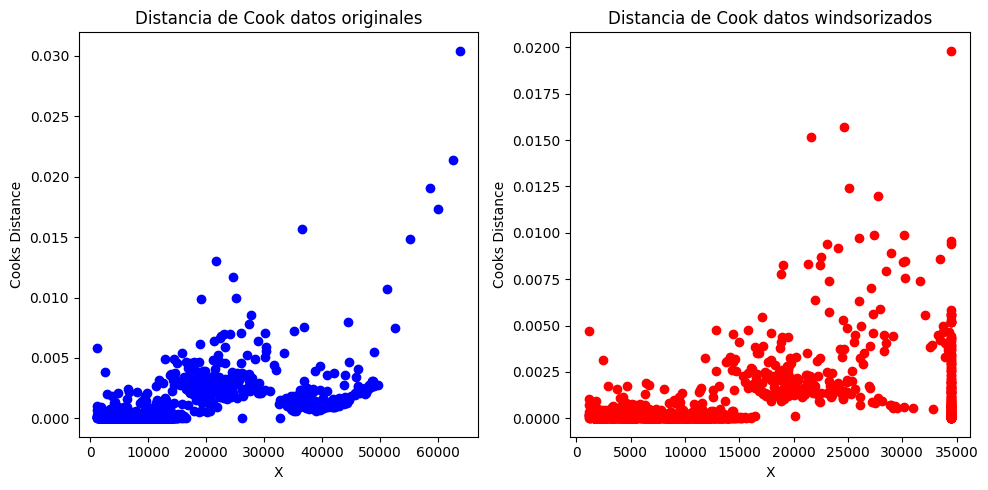

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Primer subplot
axs[0].scatter(data_num.charges, cooks_distance[0], color='blue')
axs[0].set_title('Distancia de Cook datos originales')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Cooks Distance')

# Segundo subplot
axs[1].scatter(data_wind.charges, cooks_distance1[0], color='red')
axs[1].set_title('Distancia de Cook datos windsorizados')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Cooks Distance')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [70]:
out = np.where(cooks_distance[0]>0.01)
d_out = data_num.iloc[out]
d_out

,age,bmi,children,smoker_num,charges
34,28,36.400,1,0,51194.55914
321,26,29.640,4,1,24671.66334
543,54,47.410,0,0,63770.42801
577,31,38.095,1,0,58571.07448
818,33,35.530,0,0,55135.40209
1011,61,33.330,4,1,36580.28216
1026,23,18.715,0,1,21595.38229
1229,52,34.485,3,0,60021.39897
1299,45,30.360,0,0,62592.87309


In [74]:
out = np.where(cooks_distance1[0]>0.01)
d_out = data_w.iloc[out]
d_out

,age,bmi,children,charges,smoker_num
219,24,23.210,0,25081.767840,1
321,26,29.640,4,24671.663340,1
516,20,35.310,1,27724.288750,1
1011,61,33.330,4,34524.777625,1
1026,23,18.715,0,21595.382290,1


Los valores atípicos son legítimos y representan eventos o fenómenos reales en los datos, eliminarlos puede resultar en una pérdida de información importante y sesgar el análisis.

Veremos si afectan significativamente el modelo: Si los valores atípicos tienen una influencia mínima en el rendimiento del modelo y no afectan sustancialmente los resultados, puede ser innecesario eliminarlos y puede preferirse mantener la integridad de los datos.

Trabajaremos con los datos windsorizados, ya que los modelos de regresión lineal son sensibles a los valores atípicos, lo que significa que incluso un solo valor atípico puede influir significativamente en los coeficientes y en la precisión del modelo. La windsorización puede reducir este efecto al restringir el impacto de los valores atípicos, que decidimos no eliminar porque creemos que pueden tener cierto valor predictivo.

También por la estabilidad del modelo: al mitigar el impacto de los valores atípicos, la windsorización puede hacer que el modelo de regresión lineal sea más estable y generalizable, lo que puede mejorar su rendimiento en datos nuevos o desconocidos